<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Defining-the-Generative-Model" data-toc-modified-id="Defining-the-Generative-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Defining the Generative Model</a></span><ul class="toc-item"><li><span><a href="#Prior" data-toc-modified-id="Prior-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Prior</a></span></li><li><span><a href="#Simulator-(Implicit-Likelihood-Function)" data-toc-modified-id="Simulator-(Implicit-Likelihood-Function)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Simulator (Implicit Likelihood Function)</a></span></li><li><span><a href="#Loading-Real-Data" data-toc-modified-id="Loading-Real-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Loading Real Data</a></span></li><li><span><a href="#Generative-Model" data-toc-modified-id="Generative-Model-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Generative Model</a></span></li></ul></li><li><span><a href="#Prior-Checking" data-toc-modified-id="Prior-Checking-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prior Checking</a></span></li><li><span><a href="#Defining-the-Neural-Approximator" data-toc-modified-id="Defining-the-Neural-Approximator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Defining the Neural Approximator</a></span><ul class="toc-item"><li><span><a href="#Summary-Network" data-toc-modified-id="Summary-Network-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Summary Network</a></span></li><li><span><a href="#Inference-Network" data-toc-modified-id="Inference-Network-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Inference Network</a></span></li><li><span><a href="#Amortized-Posterior" data-toc-modified-id="Amortized-Posterior-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Amortized Posterior</a></span></li></ul></li><li><span><a href="#Defining-the-Configurator" data-toc-modified-id="Defining-the-Configurator-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Defining the Configurator</a></span></li><li><span><a href="#Defining-the-Trainer" data-toc-modified-id="Defining-the-Trainer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Defining the Trainer</a></span></li><li><span><a href="#Training-Phase" data-toc-modified-id="Training-Phase-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training Phase</a></span><ul class="toc-item"><li><span><a href="#Inspecting-the-Loss" data-toc-modified-id="Inspecting-the-Loss-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Inspecting the Loss</a></span></li></ul></li><li><span><a href="#Validation-Phase" data-toc-modified-id="Validation-Phase-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Validation Phase</a></span><ul class="toc-item"><li><span><a href="#Inspecting-the-Latent-Space" data-toc-modified-id="Inspecting-the-Latent-Space-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Inspecting the Latent Space</a></span></li><li><span><a href="#Simulation-Based-Calibration---Rank-Histograms" data-toc-modified-id="Simulation-Based-Calibration---Rank-Histograms-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Simulation-Based Calibration - Rank Histograms</a></span></li><li><span><a href="#Simulation-Based-Calibration---Rank-ECDF" data-toc-modified-id="Simulation-Based-Calibration---Rank-ECDF-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Simulation-Based Calibration - Rank ECDF</a></span></li><li><span><a href="#Inferential-Adequacy-(Global)" data-toc-modified-id="Inferential-Adequacy-(Global)-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Inferential Adequacy (Global)</a></span></li></ul></li><li><span><a href="#Inference-Phase" data-toc-modified-id="Inference-Phase-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Inference Phase</a></span><ul class="toc-item"><li><span><a href="#Bivariate-Posteriors" data-toc-modified-id="Bivariate-Posteriors-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Bivariate Posteriors</a></span><ul class="toc-item"><li><span><a href="#Standalone" data-toc-modified-id="Standalone-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>Standalone</a></span></li><li><span><a href="#Compared-to-Prior" data-toc-modified-id="Compared-to-Prior-8.1.2"><span class="toc-item-num">8.1.2&nbsp;&nbsp;</span>Compared to Prior</a></span></li></ul></li><li><span><a href="#Posterior-Retrodictive-Checks" data-toc-modified-id="Posterior-Retrodictive-Checks-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Posterior Retrodictive Checks</a></span></li></ul></li></ul></div>

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join("../../..")))
import datetime
from functools import partial

import numpy as np
import pandas as pd
import tensorflow as tf

In [6]:
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, SequentialNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer

<h1>Introduction</h1>
<br>
In this tutorial, we will illustrate how to perform posterior inference on simple, stationary SIR-like models (complex models will be tackled in a further notebook). SIR-like models comprise suitable illustrative examples, since they generate time-series and their outputs represent the results of solving a system of ordinary differential equations (ODEs).

The details for tackling stochastic epidemiological models are described in our corresponding paper, which you can consult for a more formal exposition and a more comprehensive treatment of neural architectures:

<em>OutbreakFlow: Model-based Bayesian inference of disease outbreak dynamics with invertible neural networks and its application to the COVID-19 pandemics in Germany</em> https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009472

In [5]:
RNG = np.random.default_rng(2022)

## Defining the Generative Model

As described in our [very first notebook](Intro_Amortized_Posterior_Estimation.ipynb), a generative model consists of a prior (encoding suitable parameter ranges) and a simulator (generating data given simulations). Our underlying model distinguishes between susceptible, $S$, infected, $I$, and recovered, $R$, individuals with infection and recovery occurring at a constant transmission rate $\lambda$ and constant recovery rate $\mu$, respectively. The model dynamics are governed by the following system of ODEs:

$$
\begin{align}
    \frac{dS}{dt} &= -\lambda\,\left(\frac{S\,I}{N}\right) \\
    \frac{dI}{dt} &= \lambda\,\left(\frac{S\,I}{N}\right) - \mu\,I \\
    \frac{dR}{dt} &= \mu\,I,
\end{align}
$$

with $N = S + I + R$ denoting the total population size. For the purpose of forward inference (simulation), we will use a time step of $dt = 1$, corresponding to daily case reports. In addition to the ODE parameters $\lambda$ and $\mu$, we consider a reporting delay parameter $L$ and a dispersion parameter $\psi$, which affect the number of reported infected individuals via a negative binomial disttribution (https://en.wikipedia.org/wiki/Negative_binomial_distribution):

$$
\begin{equation}
    I_t^{(obs)} \sim \textrm{NegBinomial}(I^{(new)}_{t-L}, \psi),
\end{equation}
$$

In this way, we connect the latent disease model to an observation model, which renders the relationship between parameters and data a stochastic one. Note, that the observation model induces a further parameter $\psi$, responsible for the dispersion of the noise.
Finally, we will also treat the number of initially infected individuals, $I_0$ as an unknown parameter (having its own prior distribution).

### Prior

We will place the following prior distributions over the five model parameters, summarized in the table below:

$$
\begin{aligned}
& \text {Table 1. Description of model parameters and corresponding prior distributions}\\
&\begin{array}{lcl}
\hline \hline \text { Description} & \text { Symbol } & \text { Prior Distribution } \\
\hline \hline \text{Initial transmission rate} & \text{$\lambda$} & \text{$\textrm{LogNormal}(\log(0.4), 0.5)$} \\
\text{Recovery rate of infected individuals} & \text{$\mu$} & \text{$\textrm{LogNormal}(\log(1/8), 0.2)$} \\
\text{Reporting delay (lag)} & \text{$L$} & \text{$\textrm{LogNormal}(\log(8), 0.2)$} \\
\text{Number of initially infected individuals} & \text{$I_0$} & \text{$\textrm{Gamma}(2, 20)$} \\
\text{Dispersion of the negative binomial distribution} & \text{$\psi$} & \text{$\textrm{Exponential}(5)$} \\
\hline
\end{array}
\end{aligned}
$$

How did we come up with these priors? In this case, we rely on the domain expertise and previous research by https://www.science.org/doi/10.1126/science.abb9789. In addition, the new parameter $\psi$ follows an exponential distribution, which restricts it to positive numbers. Below is the implementation of these priors:

In [7]:
def model_prior():
    """Generates random draws from the prior."""

    lambd = RNG.lognormal(mean=np.log(0.4), sigma=0.5)
    mu = RNG.lognormal(mean=np.log(1 / 8), sigma=0.2)
    D = RNG.lognormal(mean=np.log(8), sigma=0.2)
    I0 = RNG.gamma(shape=2, scale=20)
    psi = RNG.exponential(5)
    return np.array([lambd, mu, D, I0, psi])

In [8]:
prior = Prior(prior_fun=model_prior, param_names=[r"$\lambda$", r"$\mu$", r"$L$", r"$I_0$", r"$\psi$"])

During training, we will also standardize the prior draws, that is, ensure zero means and unit scale. We will do this purely for technical reasons - neural networks like scaled values. In addition, our current prior ranges differ vastly, so each parameter will contribute disproportionately to the loss function.

Here, we will use the `estimate_means_and_stds()` method of a `Prior` instance, which will estimate the prior means and standard deviations from random draws. We could have also just taken the analytic means and standard deviations, but these may not be available in all settings (e.g., implicit priors).

<strong>Caution:</strong> Make sure you have a seed or you set a seed whenever you are doing a Monte-Carlo estimation, since your results might differ slightly due to the empirical variation of the estimates!

In [9]:
prior_means, prior_stds = prior.estimate_means_and_stds()

### Simulator (Implicit Likelihood Function)

In [10]:
from scipy.stats import nbinom


def convert_params(mu, phi):
    """Helper function to convert mean/dispersion parameterization of a negative binomial to N and p,
    as expected by numpy.

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """

    r = phi
    var = mu + 1 / r * mu**2
    p = (var - mu) / var
    return r, 1 - p


def stationary_SIR(params, N, T, eps=1e-5):
    """Performs a forward simulation from the stationary SIR model given a random draw from the prior,"""

    # Extract parameters and round I0 and D
    lambd, mu, D, I0, psi = params
    I0 = np.ceil(I0)
    D = int(round(D))

    # Initial conditions
    S, I, R = [N - I0], [I0], [0]

    # Reported new cases
    C = [I0]

    # Simulate T-1 timesteps
    for t in range(1, T + D):

        # Calculate new cases
        I_new = lambd * (I[-1] * S[-1] / N)

        # SIR equations
        S_t = S[-1] - I_new
        I_t = np.clip(I[-1] + I_new - mu * I[-1], 0.0, N)
        R_t = np.clip(R[-1] + mu * I[-1], 0.0, N)

        # Track
        S.append(S_t)
        I.append(I_t)
        R.append(R_t)
        C.append(I_new)

    reparam = convert_params(np.clip(np.array(C[D:]), 0, N) + eps, psi)
    C_obs = RNG.negative_binomial(reparam[0], reparam[1])
    return C_obs[:, np.newaxis]

As you can see, in addition to the parameters, our simulator requires two further arguments: the total population size $N$ and the time horizon $T$. These are quantities over which we can amortize (i.e., context variables), but for this example, we will just use the population of Germany and the first two weeks of the pandemics (i.e., $T=14$), in the same vein as https://www.science.org/doi/10.1126/science.abb9789.

### Loading Real Data

We will define a simple helper function to load the actually reported cases for the first 2 weeks in Germany.

In [11]:
def load_data():
    """Helper function to load cumulative cases and transform them to new cases."""

    confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    confirmed_cases = pd.read_csv(confirmed_cases_url, sep=",")

    date_data_begin = datetime.date(2020, 3, 1)
    date_data_end = datetime.date(2020, 3, 15)
    format_date = lambda date_py: f"{date_py.month}/{date_py.day}/{str(date_py.year)[2:4]}"
    date_formatted_begin = format_date(date_data_begin)
    date_formatted_end = format_date(date_data_end)

    cases_obs = np.array(
        confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", date_formatted_begin:date_formatted_end]
    )[0]
    new_cases_obs = np.diff(cases_obs)
    return new_cases_obs

We then collect the context and real data into a Python dictionary for convenience.

In [12]:
config = {"T": 14, "N": 83e6, "obs_data": load_data()}

Since we won't vary the context variables during training, we can also define our simulator with fixed keyword arguments with the help of the `partial` function:

In [13]:
simulator = Simulator(simulator_fun=partial(stationary_SIR, T=config["T"], N=config["N"]))

Thus, whenever we call the `simulator` object, it will always use the keyword arguments provided to the `partial` function. Also, pay attention that we are passing the simulator function as a `simulator_fun` argument. A `Simulator` instance can also be initialized with a `batched_simulator_fun`, which implies that the simulator works on multiple (batched), instead of single, random draws from the prior.

### Generative Model

We now connect the prior and the simulator through the `GenerativeModel` wrapper:

In [14]:
model = GenerativeModel(prior, simulator, name="basic_covid_simulator")

INFO:root:Performing 2 pilot runs with the basic_covid_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 14, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


## Prior Checking

Any principled Bayesian workflow requires some prior predictive or prior pushforward checks to ensure that the prior specification is consistent with domain expertise (see https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html). The BayesFlow library provides some rudimentary visual tools for performing prior checking. For instance, we can visually inspect the joint prior in the form of bivariate plots:

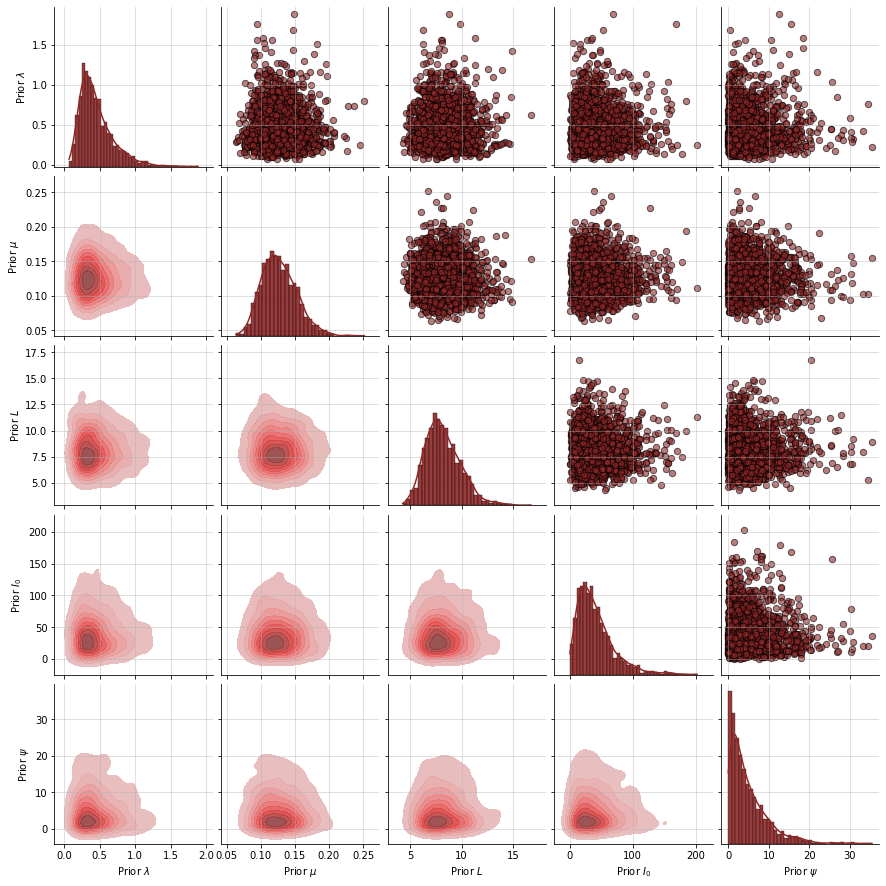

In [15]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

## Defining the Neural Approximator

We can now proceed to define our BayesFlow neural architecture, that is, combine a summary network with an invertible inference network.

### Summary Network

Since our simulator outputs 3D tensors of shape ``(batch_size, T = 14, 1)``, we need to reduce this three-dimensional tensor into a two-dimensional tensor of shape ``(batch_size, summary_dim)``. Our model outputs are actually so simple that we could have just removed the trailing dimension of the raw outputs and simply fed the data directly to the inference network.

However, for the purpose of illustration (and generalization), we will create a more elaborate summary network consisting of 1D convolutional layers (https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/blocks/1d-convolution) followed by a Long Short-Term Memory (LSTM) network (https://colah.github.io/posts/2015-08-Understanding-LSTMs/). Such an architecture not only does what we want, but also generalizes to much more complex models and longer time-series of varying time steps, see for instance our ``OutbreakFlow`` architecture:

https://arxiv.org/abs/2010.00300

Feel free to experiment with different summary architectures as well!

In [16]:
summary_net = SequentialNetwork()

### Inference Network

In [20]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=3)

### Amortized Posterior

We can now connect the summary and inference networks via the `AmortizedPosterior` wrapper:

In [22]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="covid_amortizer")

Note, that the `name` keyword argument is optional, but it is good practice to name your models and amortizers.

## Defining the Configurator

As a reminder, a configurator acts as an intermediary between a generative model and an amortizer:

<img src=img/trainer_connection.png width=75%>

In other words, we need to ensure the outputs of the forward model are suitable for processing with neural networks. Currently, they are not, since our data $\boldsymbol{x}_{1:T}$ consists of large integer (count) values. However, neural networks like scaled data. Furthermore, our parameters $\boldsymbol{\theta}$ exhibit widely different scales due to their prior specification and role in the simulator, so we will standardize them using our previously computed prior means and standard deviations. In addition, ODE models are prone to divergences and exploding outputs, which will mess up our training. In sum, our configurator does the following:

1. Initializes a new dictionary (line 7).
2. Performs a log-transform on the simulated data and convert it to `float32` type (line 10).
3. Converts the prior draws to `float32` type and standardizes them (lines 13 - 14).
4. Removes potentially problematic simulations from the batch (lines 17 - 19).

In [23]:
def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Prepare placeholder dict
    out_dict = {}

    # Convert data to logscale
    logdata = np.log1p(forward_dict["sim_data"]).astype(np.float32)

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds

    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(logdata), axis=(1, 2))
    if not np.all(idx_keep):
        print("Invalid value encountered...removing from batch")

    # Add to keys
    out_dict["summary_conditions"] = logdata[idx_keep]
    out_dict["parameters"] = params[idx_keep]

    return out_dict

## Defining the Trainer

Finally, we are in a position to define our `Trainer` instance. Notice that we also pass out custom `configurator` function to the constructer. The default configurator won't do in this case!

Note, that you should supply a `checkpoint_path` for the `Trainer` instance, if you don't want to save the neural approximators manually!

In [24]:
# change var_obs
trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configure_input)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Great, the trainer informs us that the consistency check (i.e., simulation -> configuration -> transformation -> loss computation) was successful. We can now train our networks on epidemiological simulations. We can also check out the number of trainable neural network parameters for the composite approximator:

In [25]:
amortizer.summary()

Model: "covid_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_1 (Inver  multiple                 222810    
 tibleNetwork)                                                   
                                                                 
 sequential_network (Sequent  multiple                 91178     
 ialNetwork)                                                     
                                                                 
Total params: 313,988
Trainable params: 313,958
Non-trainable params: 30
_________________________________________________________________


## Training Phase

Ready to train! Since our simulator is pretty fast, we can safely go with online training. Let's glean the time taken for a batch of $32$ simulations:

In [27]:
%%time
_ = model(32)

Wall time: 20.9 ms


We will train for $10$ epochs using $500$ iterations of $32$ simulations which amounts to a total of $10 \times 500 \times 32 = 160000$ simulations performed.

In [28]:
h = trainer.train_online(epochs=10, iterations_per_epoch=500, batch_size=32)

Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

### Inspecting the Loss

Following our online simulation-based training, we can quickly visualize the loss trajectory using the `plot_losses` function from the `diagnostics` module.

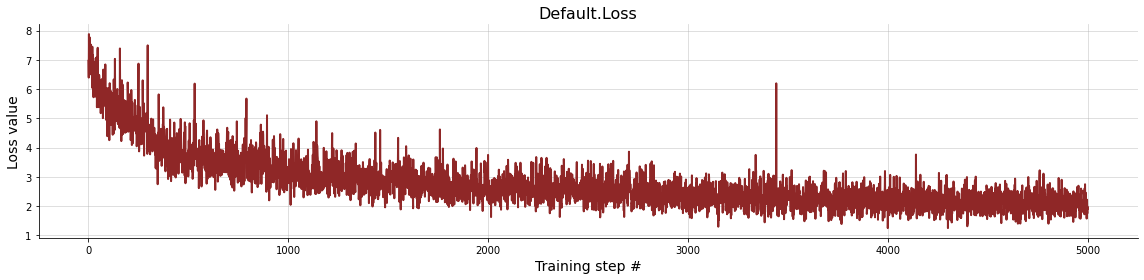

In [29]:
f = diag.plot_losses(h)

Great, it seems that our approximator has converged! Before we get too excited and throw our networks at real data, we need to make sure that they meet our expectations <em>in silico</em>, that is, given the small world of simulations the networks have seen.

## Validation Phase

### Inspecting the Latent Space

A quick and useful diagnostic is to check whether the marginal latent distribution $p(\boldsymbol{z})$ has the prescribed probabilistic structure. Since, by default, we optimize the amortizer with the Kullback-Leibler (KL) loss (also known as maximum likelihood training, which is not to be confused with maximum likelihood estimation!), we expect to observe approximately Gaussian latent space with independent axes. Moreover, since the trainer also keeps an internal `SimulationMemory` instance, we can also directly call it's `diagnose_latent2d` method (also available in the `diagnostics` module):

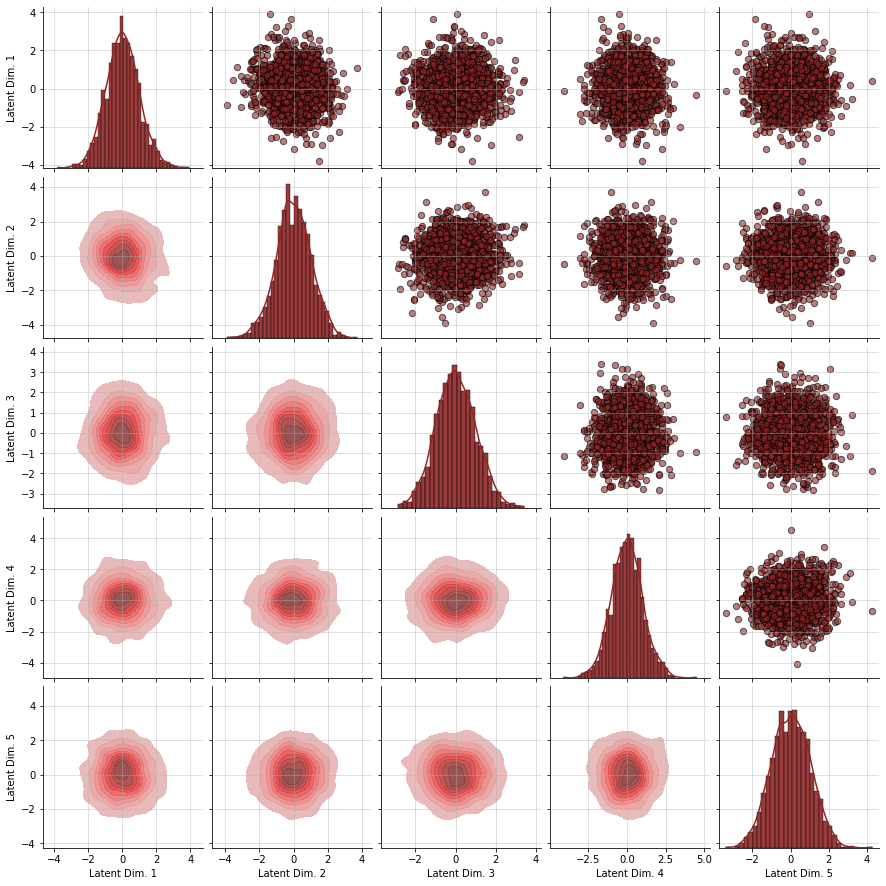

In [30]:
f = trainer.diagnose_latent2d()

### Simulation-Based Calibration - Rank Histograms

As a further <strong>small world</strong> (i.e., before real data) sanity check, we can also test the calibration of the amortizer through simulation-based calibration (SBC). See the corresponding paper by Sean Talts, Michael Betancourt, Daniel Simpson, Aki Vehtari, and Andrew Gelman for more details:

https://arxiv.org/pdf/1804.06788.pdf

Accordingly, we expect to observe approximately uniform rank statistic histograms.

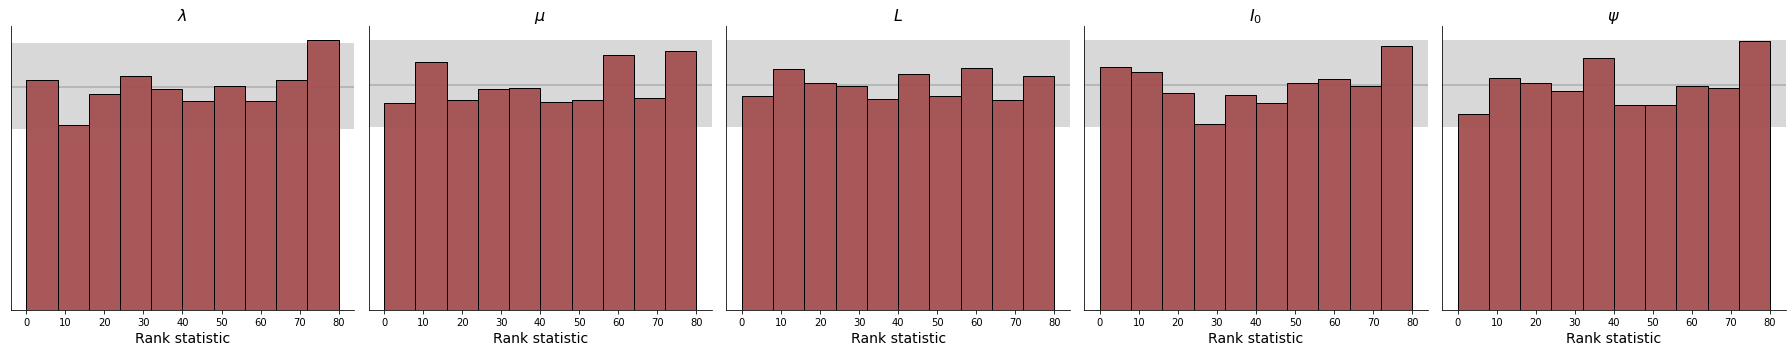

In [31]:
f = trainer.diagnose_sbc_histograms()

### Simulation-Based Calibration - Rank ECDF

For models with many parameters, inspecting many histograms can become unwieldly. Moreover, the `num_bins` hyperparameter for the construction of SBC rank histograms can be hard to choose. An alternative diagnostic approach for calibration is through empirical cumulative distribution functions (ECDF) of rank statistics. You can read more about this approach in the corresponding paper by Teemu Säilynoja, Paul-Christian Bürkner, and Aki Vehtari:

https://arxiv.org/abs/2103.10522

In order to inspect the ECDFs of marginal distributions, we will simulate $300$ new pairs of simulated data and generating parameters $(\boldsymbol{x}, \boldsymbol{\theta})$ and use the function `plot_sbc_ecdf` from the `diagnostics` module: 

In [32]:
# Generate some validation data
validation_sims = trainer.configurator(model(batch_size=300))

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)

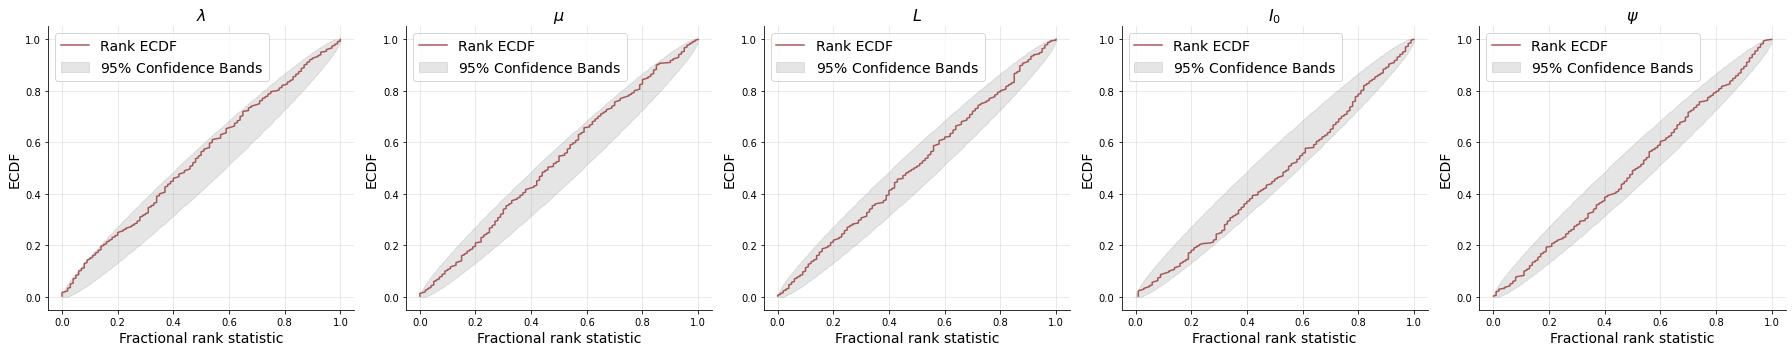

In [33]:
# Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, validation_sims["parameters"], param_names=prior.param_names)

We can also produce stacked ECDFs and compute ECDF differences for a more dynamic visualization range.

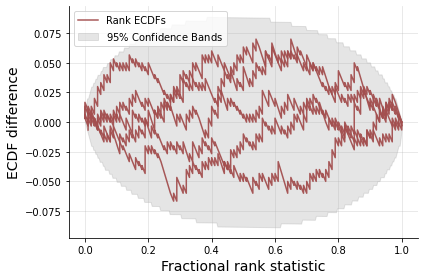

In [34]:
f = diag.plot_sbc_ecdf(post_samples, validation_sims["parameters"], stacked=True, difference=True, legend_fontsize=10)

Fianlly, we can also compute SBC histograms on the new validation data by calling the function `plot_sbc_histograms` directly.

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 3.                    Confidence intervals might be unreliable!


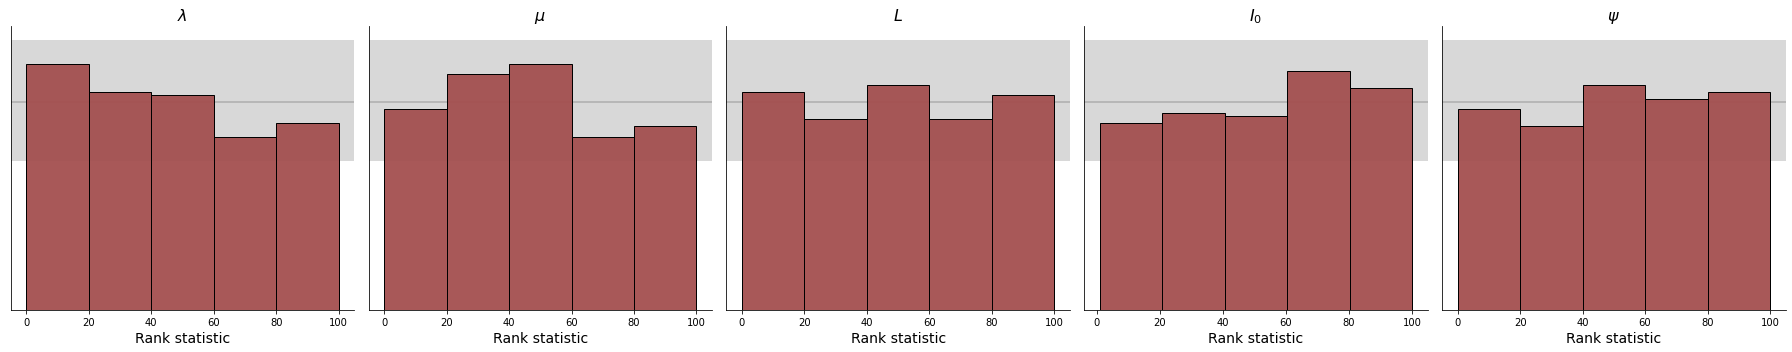

In [35]:
f = diag.plot_sbc_histograms(post_samples, validation_sims["parameters"], param_names=prior.param_names)

### Inferential Adequacy (Global)

Depending on the application, it might be interesting to see how well summaries of the full posterior (e.g., means, medians) recover the assumed true parameter values. We can test this <em>in silico</em> via the `plot_recovery` function in the `diagnostics` module. For instance, we can compare how well posterior means recover the true parameter (i.e., posterior z-score, https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html). Below, we re-use the $300$ simulations we took for computing the rank ECDFs, but obtain a larger number of posterior draws per data set for more stable results:

In [36]:
post_samples = amortizer.sample(validation_sims, n_samples=500)

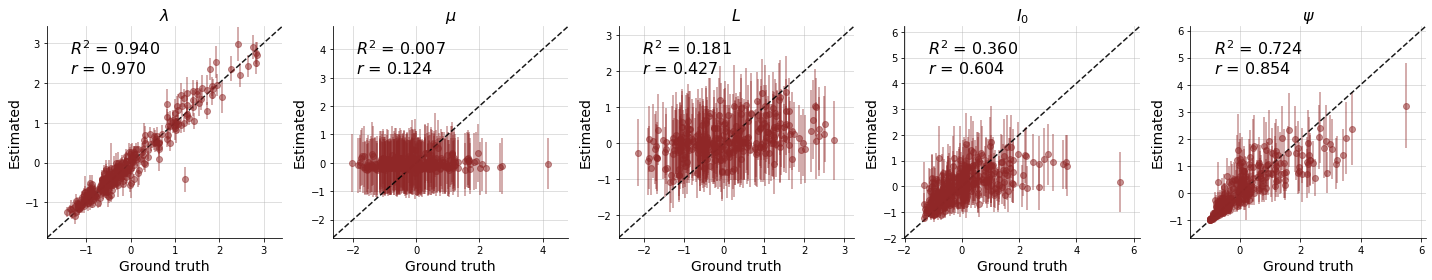

In [37]:
f = diag.plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)

## Inference Phase

We can now move on to using real data. As an important general remark: remember that the real and simulated data need to be in the same format (i.e., discrete indicators should be one-hot-encoded, transformations during training should also be applied during inference, etc.).

### Bivariate Posteriors

Finally, we can feed the real case data from the first two weeks and inspect the approximate posteriors or obtain model-based predictions.

In [38]:
# Format data into a 3D array of shape (1, n_time_steps, 1) and perform log transform
obs_data = np.log1p(config["obs_data"])[np.newaxis, :, np.newaxis].astype(np.float32)

In [40]:
# Obtain 500 posterior draws given real data
post_samples = amortizer.sample({"summary_conditions": obs_data}, 500)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples = prior_means + post_samples * prior_stds

#### Standalone

Using the `plot_posterior_2d` function from the `diagnostics` module, we can look at the bivariate posteriors in isolation:

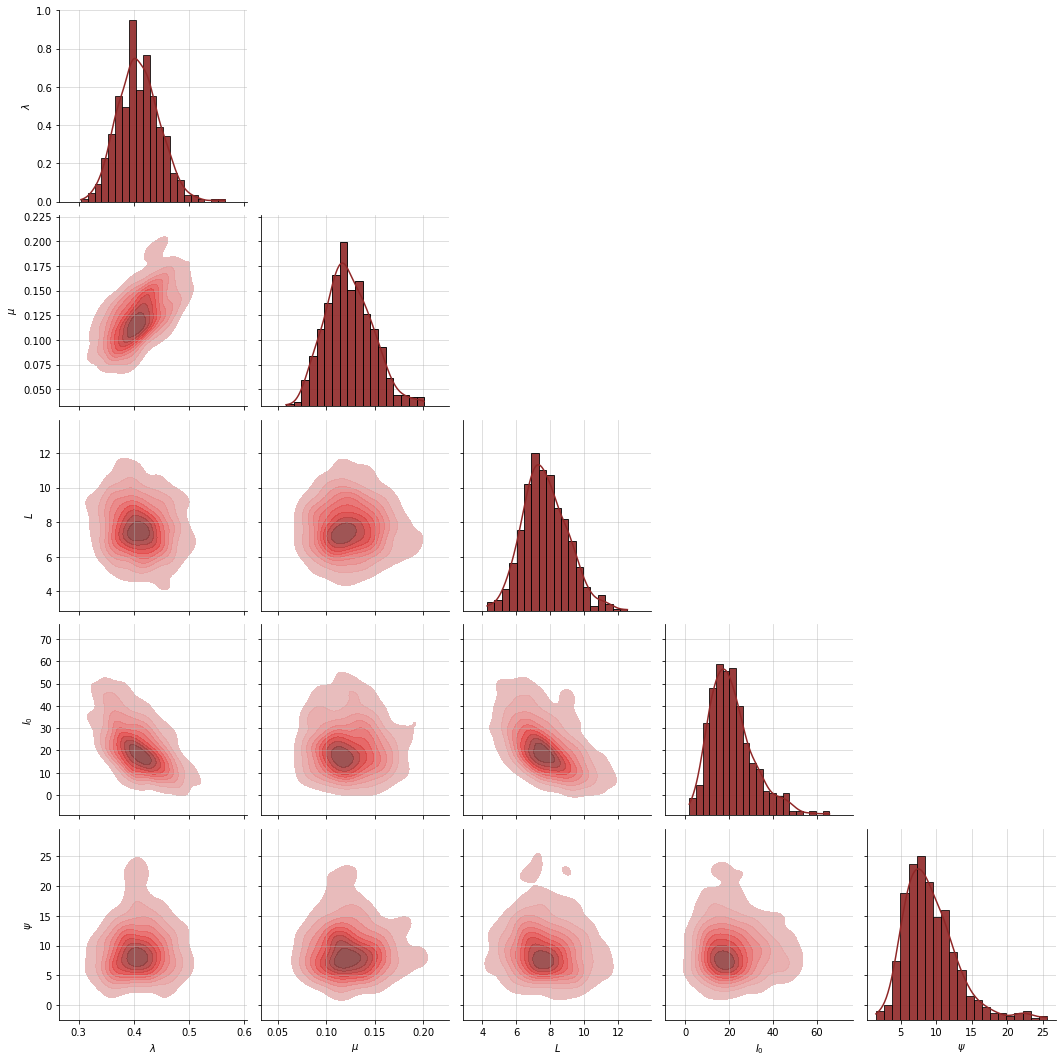

In [41]:
f = diag.plot_posterior_2d(post_samples, param_names=prior.param_names)

#### Compared to Prior

In addition, we can have a more informative plot which indicates the Bayesian surprise (i.e., difference between prior and posterior) by also supplying the prior object to the function:

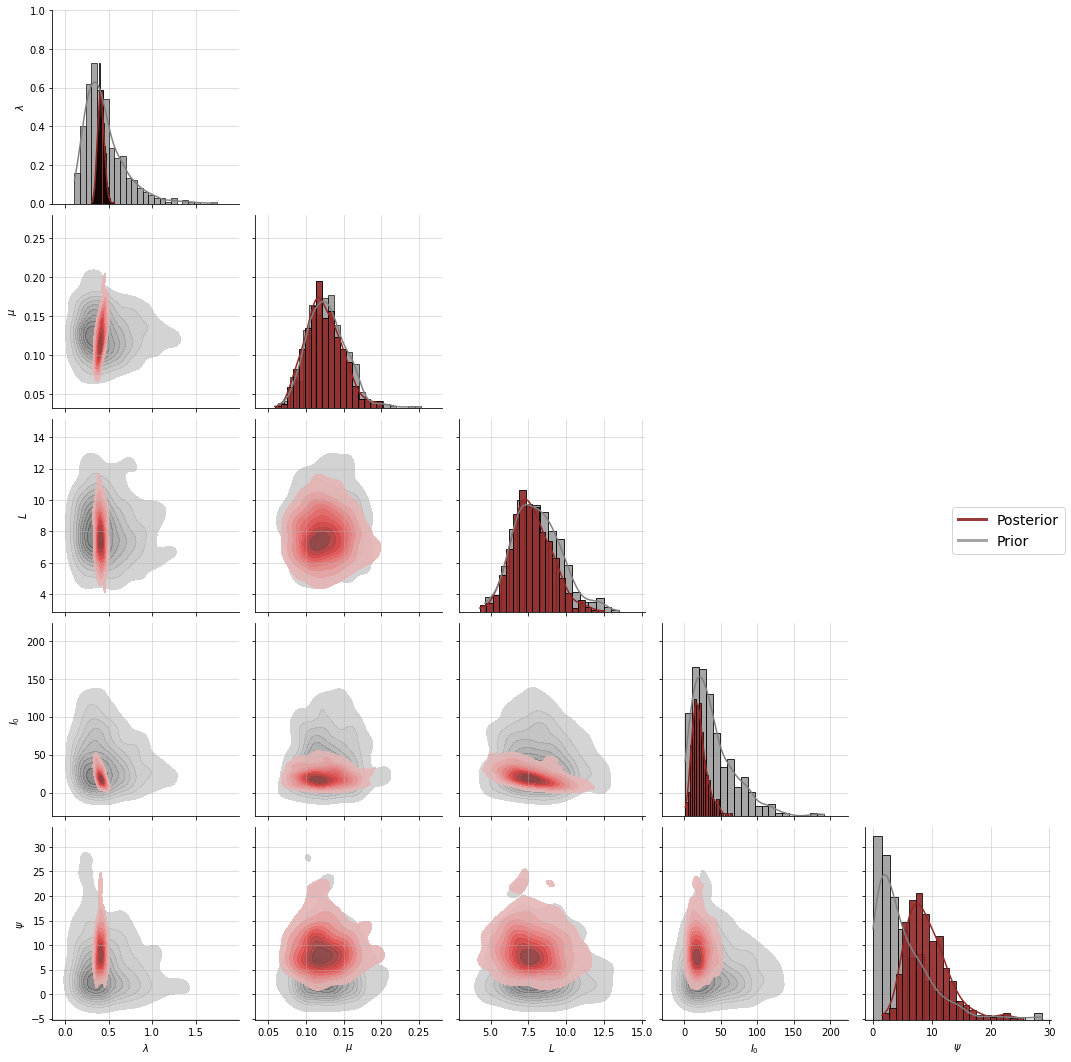

In [42]:
f = diag.plot_posterior_2d(post_samples, prior=prior)

### Posterior Retrodictive Checks

These are also called <em>posterior predictive checks</em>, but here we want to explicitly highlight the fact that we are not predicting future data but testing the <strong>generative performance</strong> or <strong>re-simulation performance</strong> of the model. In other words, we want to test how well the simulator can reproduce the actually observed data given the parameter posterior $p(\boldsymbol{\theta} | \boldsymbol{x}_{1:T})$. 

Here, we will create a custom function which plots the observed data and then overlays draws from the posterior predictive.

In [43]:
import matplotlib.pyplot as plt


def plot_ppc(config, post_samples, logscale=True, color="Blue", dummy=True, figsize=(12, 6), font_size=18):
    """
    Helper function to perform some plotting of the posterior predictive.
    """
    # Plot settings
    plt.rcParams["font.size"] = font_size

    # Remove parameters < 0
    samples = post_samples[np.sum(post_samples < 0, axis=1) == 0]

    f, ax = plt.subplots(1, 1, figsize=figsize)

    # Re-simulations
    sims = []
    for i in range(samples.shape[0]):
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim
        sim_cases = stationary_SIR(samples[i], config["N"], config["T"])[:, 0]
        sims.append(sim_cases)
    sims = np.array(sims)

    # Compute quantiles for each t = 1,...,T
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)

    # Plot median predictions and observed data
    ax.plot(np.median(sims, axis=0), label="Median predicted cases", color=color)
    ax.plot(config["obs_data"], marker="o", label="Reported cases", color="black", linestyle="dashed", alpha=0.8)

    # Add compatibility intervals (also called credible intervals)
    ax.fill_between(range(config["T"]), qs_50[0], qs_50[1], color=color, alpha=0.3, label="50% CI")
    ax.fill_between(range(config["T"]), qs_90[0], qs_90[1], color=color, alpha=0.2, label="90% CI")
    ax.fill_between(range(config["T"]), qs_95[0], qs_95[1], color=color, alpha=0.1, label="95% CI")

    # Grid and schmuck
    ax.grid(color="grey", linestyle="-", linewidth=0.25, alpha=0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("Days since pandemic onset")
    ax.set_ylabel("Number of cases")
    ax.minorticks_off()
    if logscale:
        ax.set_yscale("log")
    ax.legend(fontsize=font_size)
    return f

We can now go on and plot the re-simulations:

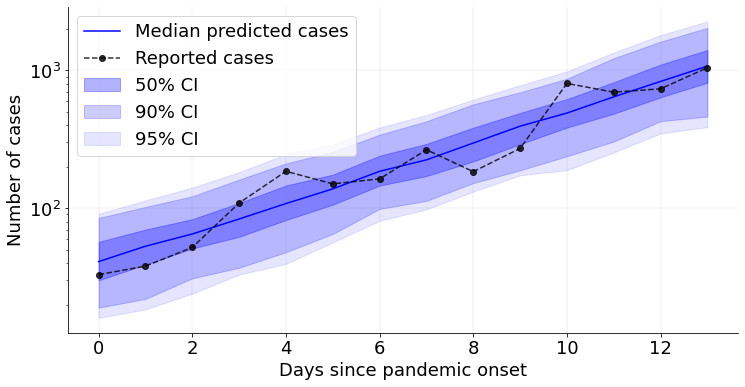

In [44]:
f = plot_ppc(config, post_samples)

That's it for this tutorial! You now know how to use the basic building blocks of `BayesFlow` to create amortized neural approximators. :)

In the [next tutorial](./PriorSensitivity_Covid19_Initial.ipynb), we will go through a <strong>prior sensitivity analysis</strong> with `BayesFlow`, which is as easy to perform as it is important for ascertaining the robustness of our inferences.